In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
Image_size = 256
Batch_size = 32
total_channels = 3

In [3]:
# let's load the dataset using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato_images',
    shuffle = True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)


Found 2152 files belonging to 3 classes.


In [4]:
classes = dataset.class_names

In [5]:
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [9]:
# Here we can see only 68 as length because it is gathered using batch size of 32 ~ 32*68 

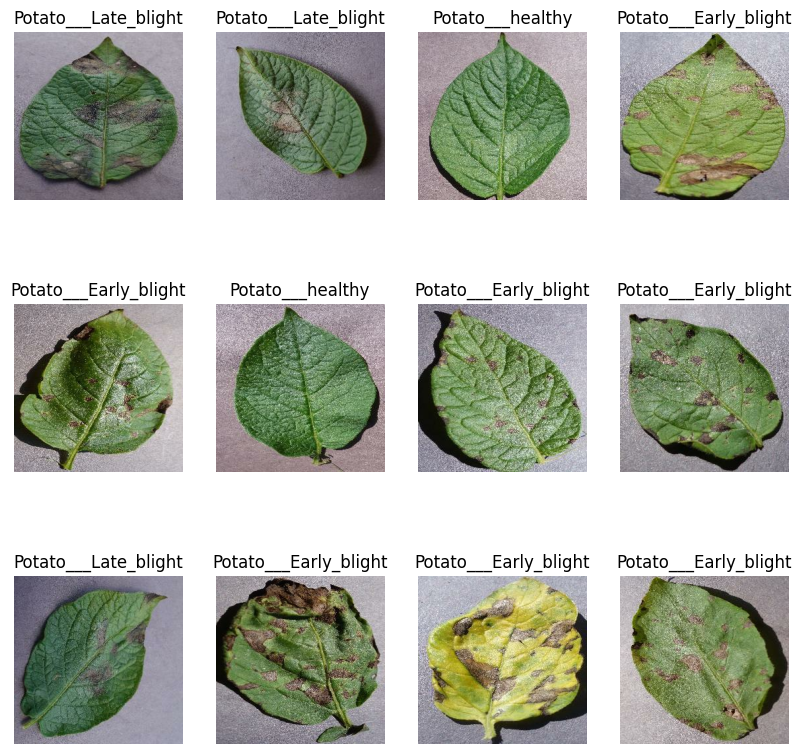

In [23]:
# dataset.take(1) will give me the one batch = 32 images
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1): 
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [24]:
# keep 80% data for training and 20 % for testing 
# In 20% let's keep 10% for the validation after each epoch and 10% for test


In [25]:
train_size = 0.8
len(dataset) * train_size 

54.400000000000006

In [26]:
train_Dataset = dataset.take(54)
len(train_Dataset)

54

In [33]:
total_test_Dataset = dataset.skip(54)
len(total_test_Dataset)

14

In [31]:
validation_size = 0.1
len(dataset)* validation_size

6.800000000000001

In [36]:
validation_dataset = total_test_Dataset.take(7)
len(validation_dataset)

7

In [37]:
test_dataset = total_test_Dataset.skip(7)
len(test_dataset)

7

In [51]:
def data_partioning(dataset, train_size = 0.8,validation_size = 0.1,test_size = 0.1,shuffle=True, shuffle_size= 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_dataset_size = train_size*dataset_size
    
    train_Dataset = dataset.take(int(train_dataset_size))
    total_test_Dataset = dataset.skip(len(train_Dataset))
    
    validation_dataset_size = int(dataset_size * validation_size)
    
    validation_dataset = total_test_Dataset.take(validation_dataset_size)

    test_dataset = total_test_Dataset.skip(len(validation_dataset))

    return train_Dataset, validation_dataset, test_dataset
                                                 
train_Dataset, validation_dataset, test_dataset = data_partioning(dataset)

print(len(train_Dataset))
print(len(validation_dataset))
print(len(test_dataset))

54
6
8


In [52]:
train_ds = train_Dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [56]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [79]:
Input_shape = (Batch_size, Image_size, Image_size, 3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=Input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = Input_shape)

In [80]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [81]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
eps = 50
history = model.fit(
    train_ds,
    epochs=eps,
    batch_size=Batch_size,
    verbose= 1,
    validation_data=validation_ds)

Epoch 1/50
54/54 [==============================] - 24s 434ms/step - loss: 0.9026 - accuracy: 0.5023 - val_loss: 0.9140 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 23s 429ms/step - loss: 0.6418 - accuracy: 0.7303 - val_loss: 0.4396 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 23s 429ms/step - loss: 0.3757 - accuracy: 0.8385 - val_loss: 0.3214 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 23s 429ms/step - loss: 0.3186 - accuracy: 0.8715 - val_loss: 0.4171 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 23s 429ms/step - loss: 0.2997 - accuracy: 0.8767 - val_loss: 0.4352 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 23s 429ms/step - loss: 0.2139 - accuracy: 0.9126 - val_loss: 0.2625 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 23s 430ms/step - loss: 0.1896 - accuracy: 0.9294 - val_loss: 0.2250 - val_accuracy: 0.8958

In [83]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 116ms/step - loss: 0.1100 - accuracy: 0.9688


In [84]:
scores


[0.11003439128398895, 0.96875]

In [85]:
history


In [86]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history.history['accuracy']

[0.5023148059844971,
 0.7303240895271301,
 0.8385416865348816,
 0.8715277910232544,
 0.8767361044883728,
 0.9126157164573669,
 0.9293981194496155,
 0.9016203880310059,
 0.9432870149612427,
 0.9398148059844971,
 0.9542824029922485,
 0.9577546119689941,
 0.9612268805503845,
 0.9577546119689941,
 0.9710648059844971,
 0.9646990895271301,
 0.9751157164573669,
 0.9710648059844971,
 0.9623842835426331,
 0.9710648059844971,
 0.9791666865348816,
 0.9866898059844971,
 0.9756944179534912,
 0.9791666865348816,
 0.9855324029922485,
 0.9878472089767456,
 0.9866898059844971,
 0.9675925970077515,
 0.9751157164573669,
 0.9809027910232544,
 0.984375,
 0.9814814925193787,
 0.9901620149612427,
 0.9907407164573669,
 0.9849537014961243,
 0.9814814925193787,
 0.9820601940155029,
 0.9890046119689941,
 0.9861111044883728,
 0.9884259104728699,
 0.9918981194496155,
 0.9895833134651184,
 0.9918981194496155,
 0.9872685074806213,
 0.9918981194496155,
 0.984375,
 0.9872685074806213,
 0.9918981194496155,
 0.993055582

In [89]:
# Plot the graph 

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

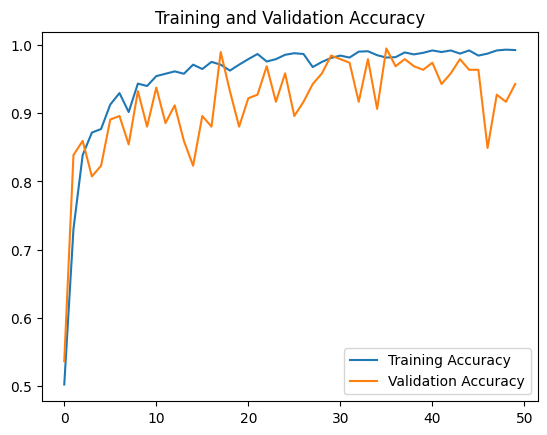

In [90]:
plt.plot(range(eps), accuracy, label='Training Accuracy')
plt.plot(range(eps), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.plot()

[]

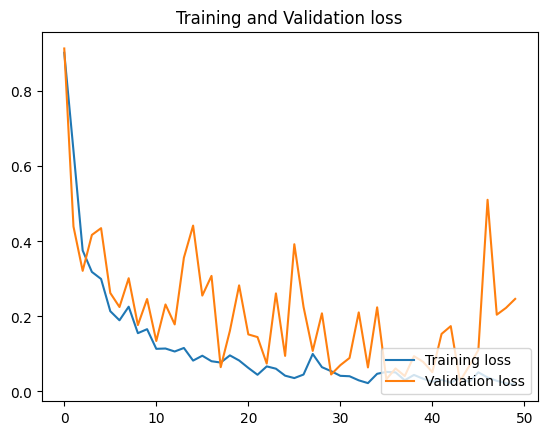

In [91]:
plt.plot(range(eps), loss, label='Training loss')
plt.plot(range(eps), validation_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')
plt.plot()

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


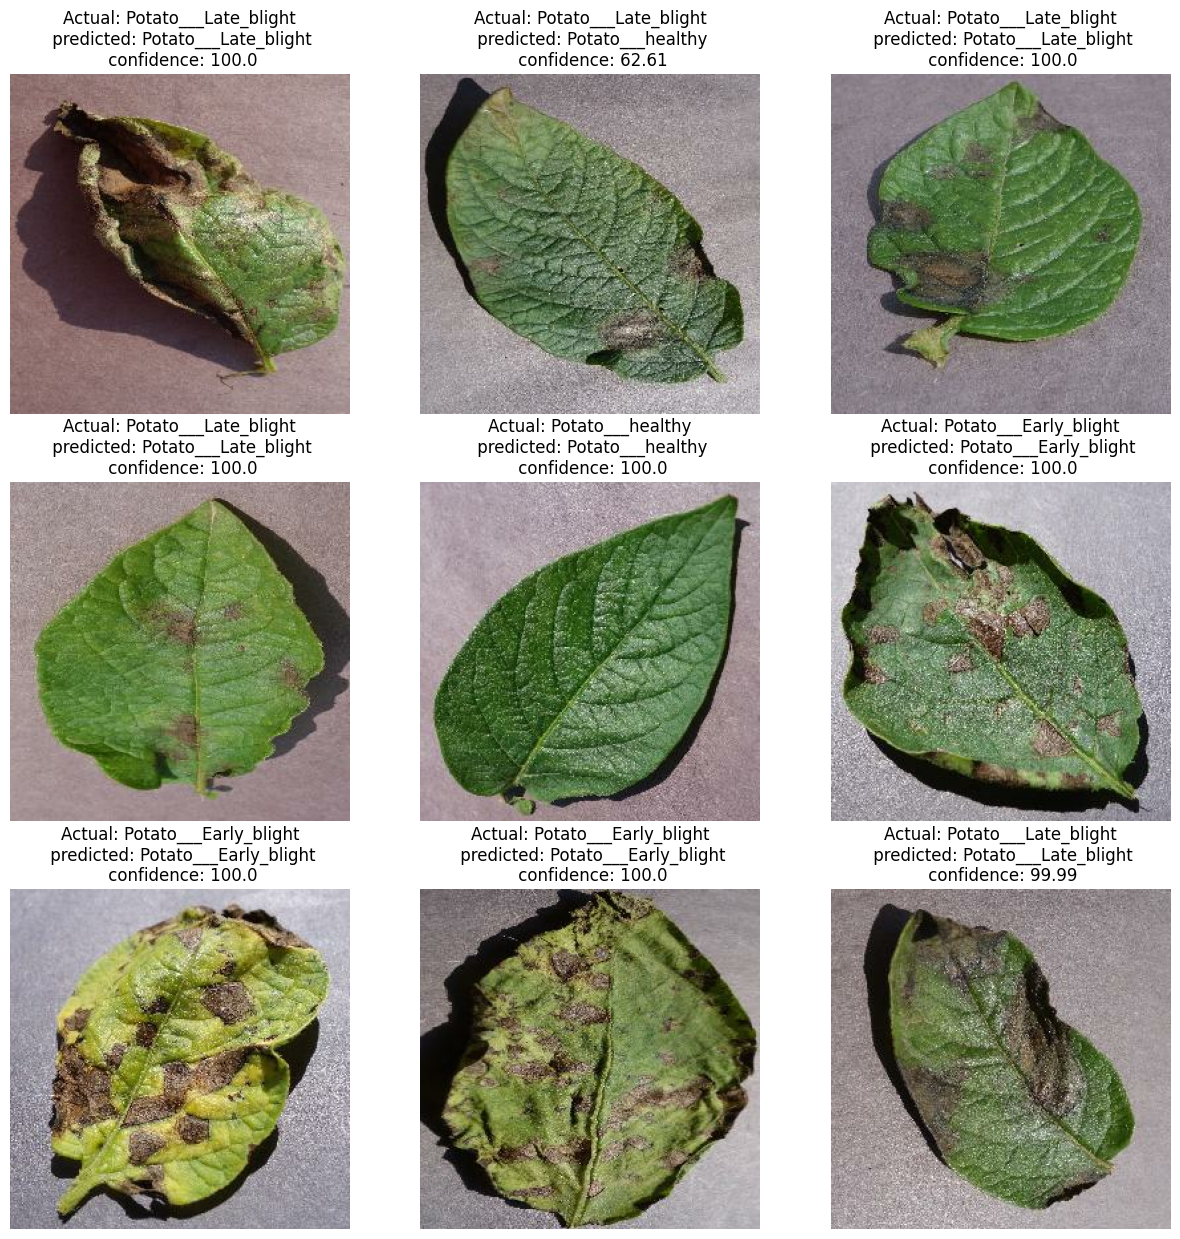

In [100]:
import numpy as np
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]
        plt.title(f'Actual: {actual_class}\n predicted: {predicted_class}\n confidence: {confidence}')
        plt.axis('off')
        

In [103]:
model_version = 1
model.save(f'./{model_version}')

INFO:tensorflow:Assets written to: ./1/assets


INFO:tensorflow:Assets written to: ./1/assets


In [104]:
model.save(f'./2')

INFO:tensorflow:Assets written to: ./2/assets


INFO:tensorflow:Assets written to: ./2/assets
